In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os


dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

mat_data = loadmat(dataset_path)
print(mat_data.keys())

Current notebook path: /home/luky/skola/KalmanNet-for-state-estimation/debug
Added /home/luky/skola/KalmanNet-for-state-estimation to sys.path
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
# initial_velocity_np = torch.from_numpy()
initial_velocity = torch.from_numpy(np.array([0,0]))

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([1487547.1250, 6395520.5000,       0.0000,       0.0000])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def verify_map_orientation(system_class, device):
    print("=== START: Testing map orientation and gradient ===")
    
    # 1. Create an ARTIFICIAL 100x100 map
    # The map will be a "Ramp": elevation increases only along the X-axis (left to right).
    # Z(x, y) = x
    grid_size = 100
    x_axis = np.linspace(0, 100, grid_size)
    y_axis = np.linspace(0, 100, grid_size)
    
    xx, yy = np.meshgrid(x_axis, y_axis)
    z_map = xx  # Ramp rises in X
    
    z_map_tensor = torch.from_numpy(z_map).float().unsqueeze(0).unsqueeze(0).to(device)
    
    # 2. Initialize the system with the artificial map
    # Important: Provide all required matrices, even if they are dummy
    dummy_F = torch.eye(4, device=device)
    dummy_Q = torch.eye(4, device=device)
    dummy_R = torch.eye(3, device=device)
    dummy_vec = torch.zeros(4, device=device)
    dummy_P0 = torch.eye(4, device=device)
    
    # Define wrapper for the artificial map
    x_min, x_max = 0, 100
    y_min, y_max = 0, 100
    
    # Use existing function h_nl_differentiable
    h_wrapper_test = lambda x: h_nl_differentiable(
        x, 
        map_tensor=z_map_tensor, 
        x_min=x_min, x_max=x_max, 
        y_min=y_min, y_max=y_max
    )
    
    # Create instance
    test_system = system_class(
        state_dim=4, obs_dim=3,
        Q=dummy_Q, R=dummy_R, Ex0=dummy_vec, P0=dummy_P0,
        F=dummy_F,
        x_axis_unique=x_axis, y_axis_unique=y_axis,
        h=h_wrapper_test,
        device=device
    )
    
    # 3. Perform measurement and gradient at a point
    # Point A: Center of the map (50, 50)
    pos_A = torch.tensor([[50.0, 50.0, 0.0, 0.0]], device=device)
    
    # Measure elevation
    # Note: h() expects [Batch, 4]; pos_A is [1, 4], which is OK.
    y_A = test_system.h(pos_A)
    height_A = y_A[0, 0].item()
    
    # Measure gradient (calls your method get_terrain_gradient)
    grad_A = test_system.get_terrain_gradient(pos_A)  # [dh/dx, dh/dy]
    grad_x_A = grad_A[0, 0].item()
    grad_y_A = grad_A[0, 1].item()
    
    print("--- Results on Ramp (Z = X) ---")
    print(f"Point A [50, 50]: Measured elevation = {height_A:.4f} (Expected ~ 50.0)")
    print(f"Gradient at A:   dX = {grad_x_A:.4f}, dY = {grad_y_A:.4f}")
    
    # 4. Evaluation
    print("\n--- DIAGNOSTICS ---")
    
    # Check elevation
    if abs(height_A - 50.0) > 1.0:
        print("ERROR: Measured elevation does not match X coordinate! Check grid_sample normalization.")
    else:
        print("Elevation OK: grid_sample interpolates correctly.")
        
    # Check orientation
    # Expect dX ~ 1.0 (positive) and dY ~ 0.0
    if grad_x_A > 0.1 and abs(grad_y_A) < 0.1:
        print("ORIENTATION OK: Gradient points along +X.")
    elif abs(grad_x_A) < 0.1 and grad_y_A > 0.1:
        print("AXES SWAPPED: Gradient points along Y, but map rises in X!")
        print("   -> Fix: In `h_nl_differentiable`, swap px and py in `torch.stack`.")
    elif grad_x_A < -0.1:
        print("MIRRORED ORIENTATION: Gradient points LEFT (-X), but ramp rises to the right!")
        print("   -> Fix: Check signs in px_norm normalization.")
    else:
        print(f"UNCLEAR RESULT: dX={grad_x_A}, dY={grad_y_A}. Check map scaling.")

# RUN
verify_map_orientation(DynamicSystemTAN, device)

=== START: Testing map orientation and gradient ===
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [0.00, 100.00]
  Y: [0.00, 100.00]
--- Results on Ramp (Z = X) ---
Point A [50, 50]: Measured elevation = 50.0000 (Expected ~ 50.0)
Gradient at A:   dX = 1.0000, dY = 0.0000

--- DIAGNOSTICS ---
Elevation OK: grid_sample interpolates correctly.
ORIENTATION OK: Gradient points along +X.
--- Results on Ramp (Z = X) ---
Point A [50, 50]: Measured elevation = 50.0000 (Expected ~ 50.0)
Gradient at A:   dX = 1.0000, dY = 0.0000

--- DIAGNOSTICS ---
Elevation OK: grid_sample interpolates correctly.
ORIENTATION OK: Gradient points along +X.


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import StateKalmanNet 
from state_NN_models import StateKalmanNet_arch2
from state_NN_models import KalmanFormer
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [7]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# import time
# import numpy as np

# def run_single_trial(trial_id, plot_failure=True):
#     # 1. PARAMETERS
#     TEST_LEN = 100 
#     EPOCHS = 200       # Fewer epochs for a quick stress test (just to see if it blows up)
#     LR = 5e-4           
#     
#     # 2. DATA (SAFE GENERATOR)
#     # Call your safe generator
#     x_single, y_single = utils.generate_data_for_map_safe(
#         system_model, num_trajectories=1, seq_len=TEST_LEN, force_initial_state_zero=False
#     )
#     x_single = x_single.to(device)
#     y_single = y_single.to(device)
#     
#     # 3. MODEL (New for each test)
#     model = StateKalmanNet(
#         system_model=system_model, device=device,
#         hidden_size_multiplier=8, output_layer_multiplier=4,
#         num_gru_layers=1, gru_hidden_dim_multiplier=8
#     ).to(device)
#     
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     
#     # 4. TRAINING LOOP
#     loss_history = []
#     status = "OK"
#     final_loss = float('inf')
#     
#     try:
#         for epoch in range(1, EPOCHS + 1):
#             model.train()
#             optimizer.zero_grad()
#             model.reset(batch_size=1, initial_state=x_single[:, 0, :])
#             
#             predictions = []
#             for t in range(1, TEST_LEN):
#                 predictions.append(model.step(y_single[:, t, :]))
#             
#             preds_tensor = torch.stack(predictions, dim=1)
#             loss = F.mse_loss(preds_tensor, x_single[:, 1:, :])
#             
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()
#             
#             val = loss.item()
#             loss_history.append(val)
#             
#             # EXPLOSION DETECTION
#             if val > 1e10 or torch.isnan(loss):
#                 status = "EXPLOSION"
#                 final_loss = val
#                 break
#             
#             # CONVERGENCE
#             if val < 1e-3:
#                 status = "CONVERGED"
#                 final_loss = val
#                 break
#                 
#         if status == "OK": 
#             final_loss = loss_history[-1]
#             
#     except RuntimeError as e:
#         status = f"CRASH ({str(e)[:50]}...)"
#         final_loss = float('nan')

#     # 5. REPORTING
#     print(f"Run {trial_id:02d}: Status={status:<10} | Final Loss={final_loss:.4f}")
#     
#     # If it blew up and we want to see why:
#     if plot_failure and (status == "EXPLOSION" or status == "CRASH"):
#         print(f"   -> Plotting failure case {trial_id}...")
#         x_gt = x_single.detach().cpu().numpy().squeeze()
#         
#         plt.figure(figsize=(10, 4))
#         plt.subplot(1, 2, 1)
#         plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', label='Ground Truth')
#         plt.title(f"FAILED RUN {trial_id} (GT Trajectory)")
#         plt.xlabel("X"); plt.ylabel("Y"); plt.legend(); plt.grid()
#         
#         plt.subplot(1, 2, 2)
#         plt.plot(loss_history)
#         plt.title("Loss History")
#         plt.yscale('log'); plt.grid()
#         plt.show()
#         
#     return status, final_loss

# def stress_test_model(num_runs=20):
#     print(f"=== STARTING STRESS TEST ({num_runs} runs) ===")
#     print("Goal: No explosions (Status != EXPLOSION). Loss below 1.0 is a bonus.")
#     print("-" * 60)
#     
#     stats = {"OK": 0, "CONVERGED": 0, "EXPLOSION": 0, "CRASH": 0}
#     losses = []
#     
#     start = time.time()
#     for i in range(1, num_runs + 1):
#         stat, loss = run_single_trial(i)
#         stats[stat if "CRASH" not in stat else "CRASH"] += 1
#         if stat in ["OK", "CONVERGED"]:
#             losses.append(loss)
#             
#     print("-" * 60)
#     print(f"STRESS TEST COMPLETED in {time.time()-start:.1f}s")
#     print(f"Results: {stats}")
#     if losses:
#         print(f"Average Loss (successful runs): {np.mean(losses):.4f}")
#         print(f"Min Loss: {np.min(losses):.4f} | Max Loss: {np.max(losses):.4f}")
#     else:
#         print("All runs failed.")

# # RUN TEST
# stress_test_model(num_runs=20)

In [8]:
# import torch
# import matplotlib.pyplot as plt

# def analyze_killer_trajectory():
#     # 1. Load data
#     try:
#         data = torch.load('killer_traj.pt')
#     except FileNotFoundError:
#         print("File 'killer_traj.pt' does not exist. You need to let the model fail first.")
#         return

#     x_true = data['x'].squeeze().numpy()  # [T, 4]
#     y_meas = data['y'].squeeze().numpy()  # [T, 3]
#     
#     print(f"Analyzing trajectory of length {len(x_true)}")
#     
#     # 2. Map boundary check
#     # (Assuming you know limits from system_model; here we hardcode or fetch)
#     # Example values:
#     X_MIN, X_MAX = 1476611.42, 1489541.47 
#     Y_MIN, Y_MAX = 6384032.63, 6400441.34
#     
#     # Check if ground truth left the map
#     x_out_min = x_true[:, 0] < X_MIN
#     x_out_max = x_true[:, 0] > X_MAX
#     y_out_min = x_true[:, 1] < Y_MIN
#     y_out_max = x_true[:, 1] > Y_MAX
#     
#     if x_out_min.any() or x_out_max.any() or y_out_min.any() or y_out_max.any():
#         print("CRITICAL: Ground truth trajectory left the map!")
#         print(f"Indices where X out: {np.where(x_out_min | x_out_max)}")
#     else:
#         print("Ground truth is within map boundaries.")

#     # 3. Visualization
#     plt.figure(figsize=(12, 10))
#     
#     # Map (top-down trajectory)
#     plt.subplot(2, 2, 1)
#     plt.plot(x_true[:, 0], x_true[:, 1], '.-')
#     plt.title("Movement on Map (X, Y)")
#     plt.xlabel("X")
#     plt.ylabel("Y")
#     plt.grid(True)
#     
#     # Elevation profile
#     plt.subplot(2, 2, 2)
#     plt.plot(y_meas[:, 0])  # First component of y is elevation
#     plt.title("Measured Elevation (Terrain Profile)")
#     plt.xlabel("Time")
#     plt.grid(True)
#     
#     # Velocities
#     plt.subplot(2, 2, 3)
#     plt.plot(x_true[:, 2], label="Vx")
#     plt.plot(x_true[:, 3], label="Vy")
#     plt.title("Velocities")
#     plt.legend()
#     plt.grid(True)
#     
#     # Innovations/Changes (Elevation derivative)
#     plt.subplot(2, 2, 4)
#     diff_height = np.diff(y_meas[:, 0])
#     plt.plot(diff_height)
#     plt.title("Elevation Change (Slope)")
#     plt.grid(True)
#     
#     plt.tight_layout()
#     plt.show()

# # Run
# analyze_killer_trajectory()

In [9]:
# def debug_killer_step_by_step(system_model, device):
#     # Load
#     checkpoint = torch.load('killer_traj.pt')
#     x_single = checkpoint['x'].to(device)
#     y_single = checkpoint['y'].to(device)
#     
#     # Initialize model and load state just before failure
#     model = StateKalmanNet(
#         system_model=system_model,
#         device=device,
#         hidden_size_multiplier=8,
#         output_layer_multiplier=4,
#         num_gru_layers=1,
#         gru_hidden_dim_multiplier=8
#     ).to(device)
#     model.load_state_dict(checkpoint['model_state'])
#     
#     model.eval()
#     
#     # Reset
#     initial_state = x_single[:, 0, :]
#     model.reset(batch_size=1, initial_state=initial_state)
#     
#     print("=== START STEP-BY-STEP DEBUG ===")
#     
#     for t in range(1, x_single.shape[1]):
#         y_t = y_single[:, t, :]
#         
#         # Save state before step
#         x_prev = model.x_filtered_prev.clone()
#         
#         # --- STEP ---
#         # You may need to add prints inside StateKalmanNet.step
#         # or extract internals manually if possible.
#         # For now we just monitor the output.
#         x_est = model.step(y_t)
#         
#         # OUTPUT ANALYSIS
#         diff = x_est - x_single[:, t, :]
#         mse = (diff**2).mean().item()
#         
#         print(f"Step {t}:")
#         print(f"  GT Pos: {x_single[0, t, :2].tolist()}")
#         print(f"  Est Pos: {x_est[0, :2].tolist()}")
#         print(f"  Error (MSE): {mse:.4f}")
#         
#         # Check Kalman Gain (if accessible from model)
#         # print(f"  Kalman Gain norm: ...") 
#         
#         if mse > 1000:  # When error exceeds threshold
#             print(f"BOMB! Error exploded at step {t}!")
#             print("Cause likely around step t-1 or t.")
#             print(f"Input measurement y_t: {y_t.tolist()}")
#             break

# debug_killer_step_by_step(system_model, device)

In [10]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from utils import utils

# TRAIN_SEQ_LEN = 100
# VALID_SEQ_LEN = 200

# NUM_TRAIN_TRAJECTORIES = 1000 
# NUM_VALID_TRAJECTORIES = 100 
# BATCH_SIZE = 256

# system_model.min_x = x_axis_unique.min()
# system_model.max_x = x_axis_unique.max()
# system_model.min_y = y_axis_unique.min()
# system_model.max_y = y_axis_unique.max()
# system_model.device = device 

# system_model.Ex0 = torch.tensor([(system_model.min_x+system_model.max_x)/2, (system_model.min_y+system_model.max_y)/2, 0.0, 0.0]).float().to(device)


# # x_train, y_train = utils.generate_data_for_map(
# #     system_model, 
# #     num_trajectories=NUM_TRAIN_TRAJECTORIES, 
# #     seq_len=TRAIN_SEQ_LEN,
# #     force_initial_state_zero=False
# # )
# x_train, y_train = utils.generate_data_for_map_safe(
#     system_model, 
#     num_trajectories=NUM_TRAIN_TRAJECTORIES, 
#     seq_len=TRAIN_SEQ_LEN,
# )

# # x_val, y_val = utils.generate_data_for_map(
# #     system_model, 
# #     num_trajectories=NUM_VALID_TRAJECTORIES, 
# #     seq_len=VALID_SEQ_LEN,
# #     force_initial_state_zero=False
# # )
# x_val, y_val = utils.generate_data_for_map_safe(
#     system_model, 
#     num_trajectories=NUM_VALID_TRAJECTORIES, 
#     seq_len=VALID_SEQ_LEN,
# )

# train_dataset = TensorDataset(x_train, y_train)
# val_dataset = TensorDataset(x_val, y_val)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [11]:
def generate_augmented_dataset(system, real_traj_tensor, num_trajectories, seq_len, trajectory_noise=0.0):

    device = system.Ex0.device
    
    deltas_full = real_traj_tensor[1:] - real_traj_tensor[:-1]
    total_len = deltas_full.shape[0]
    
    if seq_len > total_len:
        raise ValueError("Sequence is longer than source trajectory!")

    x_data = torch.zeros(num_trajectories, seq_len, system.state_dim, device=device)
    y_data = torch.zeros(num_trajectories, seq_len, system.obs_dim, device=device)
    
    MARGIN = 50.0
    safe_min_x, safe_max_x = system.min_x + MARGIN, system.max_x - MARGIN
    safe_min_y, safe_max_y = system.min_y + MARGIN, system.max_y - MARGIN

    count = 0
    while count < num_trajectories:
        start_idx = torch.randint(0, total_len - seq_len, (1,)).item()
        seq_deltas = deltas_full[start_idx : start_idx + seq_len - 1].clone()
        
        if trajectory_noise > 0:
            perturbation = torch.randn_like(seq_deltas) * trajectory_noise
            seq_deltas += perturbation

        angle = torch.rand(1, device=device) * 2 * np.pi
        c, s = torch.cos(angle), torch.sin(angle)
        R = torch.tensor([[c, -s], [s, c]], device=device)
        rotated_deltas = seq_deltas @ R.T 
        
        start_pos = torch.zeros(1, 2, device=device)
        start_pos[0, 0] = (torch.rand(1) * (safe_max_x - safe_min_x)) + safe_min_x
        start_pos[0, 1] = (torch.rand(1) * (safe_max_y - safe_min_y)) + safe_min_y

        traj_pos = torch.zeros(seq_len, 2, device=device)
        traj_pos[0] = start_pos
        traj_pos[1:] = start_pos + torch.cumsum(rotated_deltas, dim=0)
        
        if (traj_pos[:, 0].min() < system.min_x or traj_pos[:, 0].max() > system.max_x or
            traj_pos[:, 1].min() < system.min_y or traj_pos[:, 1].max() > system.max_y):
            continue 

        traj_vel = torch.cat([rotated_deltas, rotated_deltas[-1:]], dim=0)
        x_seq = torch.cat([traj_pos, traj_vel], dim=1)

        try:
            y_seq = system.measure(x_seq)
        except Exception:
            continue

        x_data[count] = x_seq
        y_data[count] = y_seq
        count += 1
        
        if count % (num_trajectories // 10 if num_trajectories >= 10 else 1) == 0:
            print(f"  Generated {count}/{num_trajectories}")

    return x_data, y_data


real_traj_np = souradniceGNSS[:2, :].T 

real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)
LIMIT_TRAIN_SOURCE = 750
train_source_tensor = real_traj_tensor[:LIMIT_TRAIN_SOURCE, :]

TRAIN_SIZE = 1000
VAL_SIZE = 1000
SEQ_LEN = 100 

x_train_aug, y_train_aug = generate_augmented_dataset(
    system_model, 
    train_source_tensor, 
    TRAIN_SIZE, 
    SEQ_LEN
)

x_val_aug, y_val_aug = generate_augmented_dataset(
    system_model, 
    train_source_tensor, 
    VAL_SIZE, 
    SEQ_LEN
)

train_loader = DataLoader(TensorDataset(x_train_aug, y_train_aug), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val_aug, y_val_aug), batch_size=256, shuffle=False)


  Generated 100/1000
  Generated 200/1000
  Generated 300/1000
  Generated 200/1000
  Generated 300/1000
  Generated 400/1000
  Generated 400/1000
  Generated 500/1000
  Generated 500/1000
  Generated 600/1000
  Generated 600/1000
  Generated 700/1000
  Generated 700/1000
  Generated 800/1000
  Generated 800/1000
  Generated 900/1000
  Generated 1000/1000
  Generated 900/1000
  Generated 1000/1000
  Generated 100/1000
  Generated 100/1000
  Generated 200/1000
  Generated 300/1000
  Generated 200/1000
  Generated 300/1000
  Generated 400/1000
  Generated 500/1000
  Generated 600/1000
  Generated 400/1000
  Generated 500/1000
  Generated 600/1000
  Generated 700/1000
  Generated 800/1000
  Generated 900/1000
  Generated 700/1000
  Generated 800/1000
  Generated 900/1000
  Generated 1000/1000
  Generated 1000/1000


Plotting sample training data...


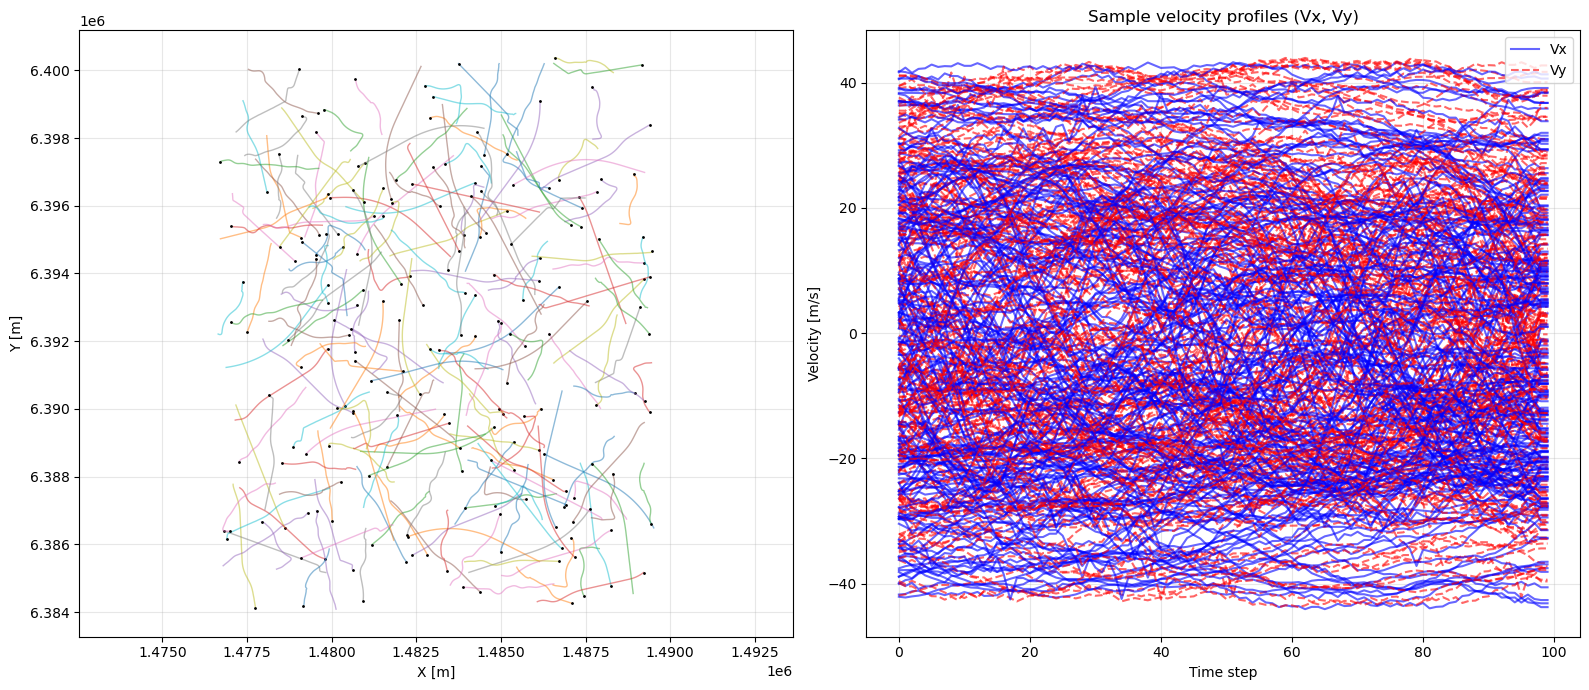

In [12]:
import matplotlib.pyplot as plt
import random
import numpy as np

def visualize_augmented_data(x_data, num_to_plot=50):
    x_np = x_data.detach().cpu().numpy()
    total_traj = x_np.shape[0]
    seq_len = x_np.shape[1]
    
    indices = random.sample(range(total_traj), min(num_to_plot, total_traj))
    
    plt.figure(figsize=(16, 7))
    
    plt.subplot(1, 2, 1)
    for i in indices:
        traj = x_np[i]
        plt.plot(traj[:, 0], traj[:, 1], alpha=0.5, linewidth=1)
        plt.plot(traj[0, 0], traj[0, 1], 'k.', markersize=2)
        
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    time_steps = np.arange(seq_len)
    
    subset_indices = indices[:num_to_plot] 
    
    for i in subset_indices:
        traj = x_np[i]
        plt.plot(time_steps, traj[:, 2], 'b-', alpha=0.6, linewidth=1.5, label='Vx' if i==subset_indices[0] else "")
        plt.plot(time_steps, traj[:, 3], 'r--', alpha=0.6, linewidth=1.5, label='Vy' if i==subset_indices[0] else "")
        
    plt.title("Sample velocity profiles (Vx, Vy)")
    plt.xlabel("Time step")
    plt.ylabel("Velocity [m/s]")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- RUN VISUALIZATION ---
print("Plotting sample training data...")
visualize_augmented_data(x_train_aug, num_to_plot=200)

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import trainer
import os

state_knet2 = StateKalmanNet(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=14,
        output_layer_multiplier=4,
        num_gru_layers=2,
        gru_hidden_dim_multiplier=12
        ).to(device)

curriculum_schedule = [
    {'seq_len': 10,  'epochs': 100, 'lr': 1e-3, 'batch_size': 256},  # Phase 1: Quick start
    {'seq_len': 100,  'epochs': 100, 'lr': 1e-3, 'batch_size': 256},  # Phase 2: Medium sequences
    {'seq_len': 500,  'epochs': 50, 'lr': 5e-4, 'batch_size': 256},  # Phase 3: Long sequences (TBPTT)
    # {'seq_len': 1000, 'epochs': 50, 'lr': 1e-4, 'batch_size': 16}   # Phase 4: Very long sequences (Fine-tuning)
]

TRAIN_SAMPLES_BASE = 1500 
VAL_SAMPLES = 500

print("=== CURRICULUM LEARNING ===")

for phase_idx, phase in enumerate(curriculum_schedule):
    seq_len = phase['seq_len']
    
    x_train, y_train = generate_augmented_dataset(
        system_model, train_source_tensor, TRAIN_SAMPLES_BASE, seq_len, trajectory_noise=0.3
    )
    x_val, y_val = generate_augmented_dataset(
        system_model, train_source_tensor, VAL_SAMPLES, seq_len
    )
    
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=phase['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=phase['batch_size'], shuffle=False)
    
    if seq_len <= 100:
        trainer.train_state_KalmanNet(
            model=state_knet2,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=phase['epochs'],
            lr=phase['lr'],
            weight_decay=1e-4,
            clip_grad=1.0,
            early_stopping_patience=20,
            print_gradient=False
        )
    else:
        trainer.train_state_KalmanNet_sliding_window(
            model=state_knet2,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=phase['epochs'],
            lr=phase['lr'],
            weight_decay_=1e-4,
            clip_grad=1.0,
            early_stopping_patience=10,
            tbptt_k=300, 
            tbptt_w=50,
            optimizer_=torch.optim.AdamW
        )
        
    save_path = f'knet_curriculum_len{seq_len}.pth'
    torch.save(state_knet2.state_dict(), save_path)
    print(f"Phase {phase_idx+1} completed. Model saved to '{save_path}'.")

DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
=== CURRICULUM LEARNING ===
  Generated 150/1500
  Generated 300/1500
  Generated 450/1500
  Generated 300/1500
  Generated 450/1500
  Generated 600/1500
  Generated 750/1500
  Generated 600/1500
  Generated 750/1500
  Generated 900/1500
  Generated 1050/1500
  Generated 900/1500
  Generated 1050/1500
  Generated 1200/1500
  Generated 1350/1500
  Generated 1200/1500
  Generated 1350/1500
  Generated 1500/1500
  Generated 50/500
  Generated 100/500
  Generated 150/500
  Generated 200/500
  Generated 1500/1500
  Generated 50/500
  Generated 100/500
  Generated 150/500
  Generated 200/500
  Generated 250/500
  Generated 300/500
  Generated 350/500
  Generated 400/500
  Generated 450/500
  Generated 250/500
  Generated 300/500
  Generated 350/500
  Generated 400/500
  Generated 450/500
  Generated 500/500
  Generated 500/500
INFO: Detected from model attribute that it returns covariance: False
INFO: Detected from model

Ref X shape: torch.Size([1, 1276, 4])
Ref Y shape: torch.Size([1, 1276, 3])


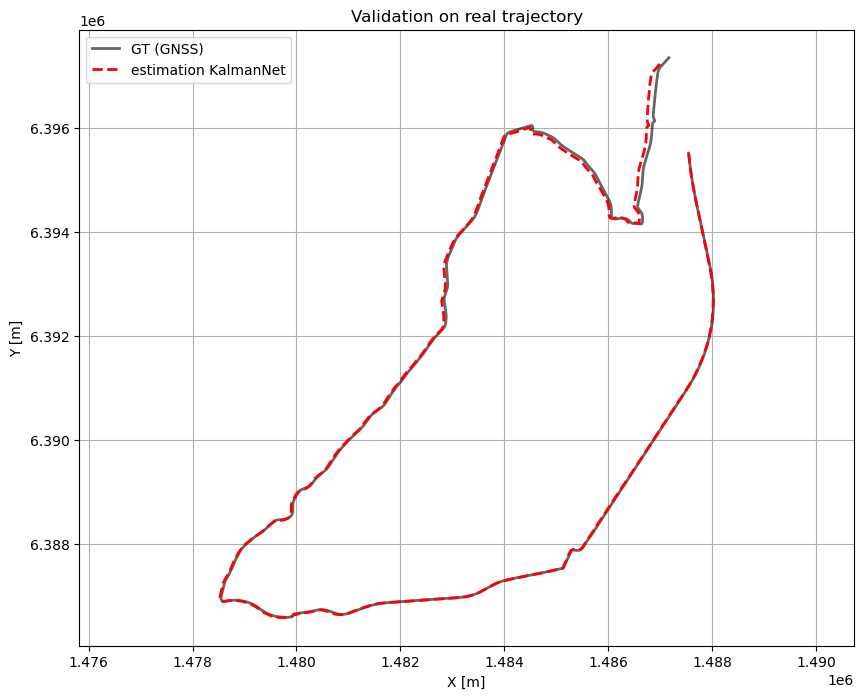


=== Results ===
Total MSE: 793.5366
Average position error (Euclidean): 42.70 m


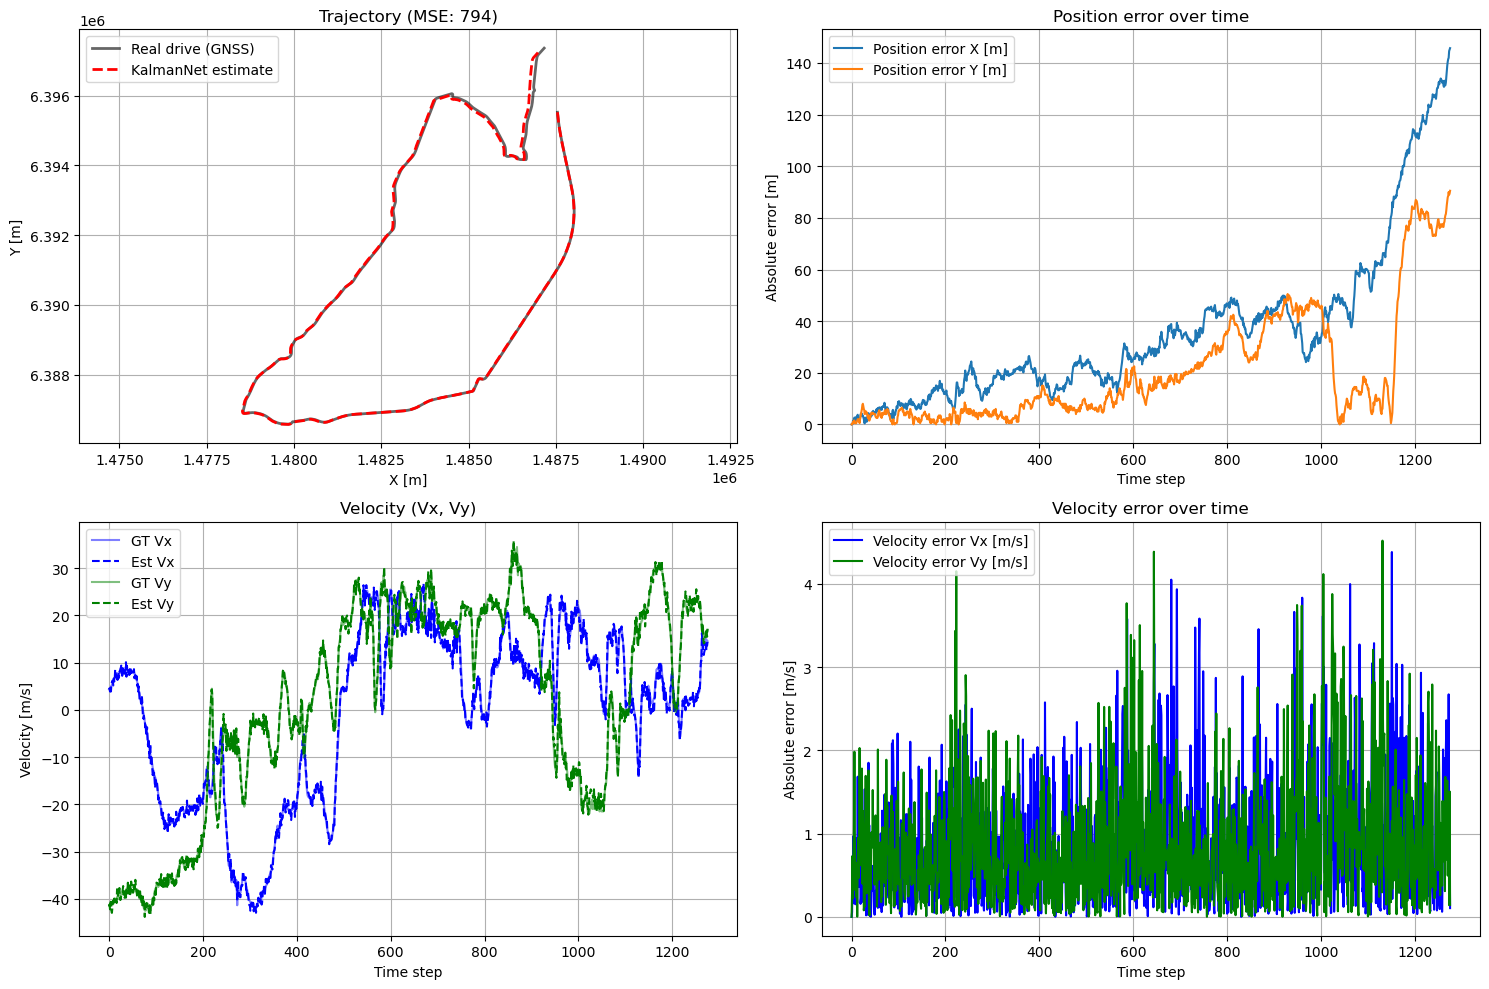

In [14]:
def get_reference_test_set(system, real_traj_tensor):
    device = system.Ex0.device

    pos_full = real_traj_tensor.clone().to(device)
    

    deltas = pos_full[1:] - pos_full[:-1] 
    last_vel = deltas[-1:]
    velocities = torch.cat([deltas, last_vel], dim=0) # [T, 2]
    
    x_traj_flat = torch.cat([pos_full, velocities], dim=1) 
    
    y_traj_flat = system.measure(x_traj_flat) # [T, 3]
    
    # [Batch=1, Seq=T, Dim]
    x_ref = x_traj_flat.unsqueeze(0) # [1, T, 4]
    y_ref = y_traj_flat.unsqueeze(0) # [1, T, 3]
    
    return x_ref, y_ref

x_test_ref, y_test_ref = get_reference_test_set(system_model, real_traj_tensor)

print(f"Ref X shape: {x_test_ref.shape}") 
print(f"Ref Y shape: {y_test_ref.shape}") 


def test_on_reference(model, x, y):
    model.eval()
    with torch.no_grad():
        initial_state = x[:, 0, :]
        model.reset(batch_size=1, initial_state=initial_state)
        
        predictions = []
        seq_len = x.shape[1]

        for t in range(1, seq_len):
            y_t = y[:, t, :]
            x_est = model.step(y_t)
            predictions.append(x_est)

        preds = torch.stack(predictions, dim=1)
        full_preds = torch.cat([initial_state.unsqueeze(1), preds], dim=1)
        
        return full_preds

x_est_ref = test_on_reference(state_knet2, x_test_ref, y_test_ref)

x_gt = x_test_ref.squeeze().cpu().numpy()
x_est = x_est_ref.squeeze().cpu().numpy()

plt.figure(figsize=(10, 8))
plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', label='GT (GNSS)', linewidth=2, alpha=0.6)
plt.plot(x_est[:, 0], x_est[:, 1], 'r--', label='estimation KalmanNet', linewidth=2)
plt.title("Validation on real trajectory")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

x_est_ref = test_on_reference(state_knet2, x_test_ref, y_test_ref)

x_gt = x_test_ref.squeeze().cpu().numpy()
x_est = x_est_ref.squeeze().cpu().numpy()


error = x_est - x_gt

squared_error = error ** 2

total_mse = np.mean(squared_error)

rmse_per_step = np.sqrt(squared_error)

print(f"\n=== Results ===")
print(f"Total MSE: {total_mse:.4f}")
print(f"Average position error (Euclidean): {np.mean(np.sqrt(squared_error[:, 0] + squared_error[:, 1])):.2f} m")

# 2. Plotting graphs
plt.figure(figsize=(15, 10))

# A) Trajectory on the map
plt.subplot(2, 2, 1)
plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', label='Real drive (GNSS)', linewidth=2, alpha=0.6)
plt.plot(x_est[:, 0], x_est[:, 1], 'r--', label='KalmanNet estimate', linewidth=2)
plt.title(f"Trajectory (MSE: {total_mse:.0f})")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.axis('equal')
plt.grid(True)

# B) Chyba Polohy v čase (X a Y)
plt.subplot(2, 2, 2)
time_steps = np.arange(len(x_gt))
plt.plot(time_steps, rmse_per_step[:, 0], label='Position error X [m]')
plt.plot(time_steps, rmse_per_step[:, 1], label='Position error Y [m]')
plt.title("Position error over time")
plt.xlabel("Time step")
plt.ylabel("Absolute error [m]")
plt.legend()
plt.grid(True)

# C) Velocity profiles (GT vs Est)
plt.subplot(2, 2, 3)
plt.plot(x_gt[:, 2], 'b-', alpha=0.5, label='GT Vx')
plt.plot(x_est[:, 2], 'b--', label='Est Vx')
plt.plot(x_gt[:, 3], 'g-', alpha=0.5, label='GT Vy')
plt.plot(x_est[:, 3], 'g--', label='Est Vy')
plt.title("Velocity (Vx, Vy)")
plt.xlabel("Time step")
plt.ylabel("Velocity [m/s]")
plt.legend()
plt.grid(True)

# D) Velocity error over time
plt.subplot(2, 2, 4)
plt.plot(time_steps, rmse_per_step[:, 2], label='Velocity error Vx [m/s]', color='blue')
plt.plot(time_steps, rmse_per_step[:, 3], label='Velocity error Vy [m/s]', color='green')
plt.title("Velocity error over time")
plt.xlabel("Time step")
plt.ylabel("Absolute error [m/s]")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()